# Deep Learning Mini-Challenge 2: Image Captioning

**Task description:** The aim of this Mini Challenge is to train an image captioning model. After the training, the model should be able to receive an image and generate a single sentence describing the captured scene. This work is strongly inspired by the paper from Vinyals: *Show and Tell: A Neural Image Caption Generator* (https://arxiv.org/pdf/1411.4555.pdf).

**Description of the dataset:** The Flickr8k data set is used for training the models. It consists of 8091 different images with varying resolutions. The images were collected from six different Flickr groups and were manually selected to include a range of scenes and situations. In addition, 5 captions are included in the dataset for each image which results in a total of 40455 captions. 

In [1]:
import os
import pickle
import wandb
import random
import itertools
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset

from sklearn.model_selection import train_test_split
from torchtext.data.utils import get_tokenizer
from torch.utils.data import DataLoader
import torchtext
from tqdm import tqdm

import torchvision
import torchvision.models as models
from torch.nn.utils.rnn import pad_packed_sequence

from nltk.translate.bleu_score import sentence_bleu

import warnings
warnings.filterwarnings('ignore')

print("torch:", torch.__version__)
print("torchtext:", torchtext.__version__)
print("torchvision:", torchvision.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

c:\Users\Simon\anaconda3\envs\pytorch181\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch: 1.8.1+cu111
torchtext: 0.9.1
torchvision: 0.9.1+cu111
device: cuda


## Import data

In [2]:
def read_labels(label_path, skip_header=True):
    '''
    Reads the labels and caption text from the captions.txt file in the specified path
    '''
    with open(label_path + "captions.txt") as f:
        if skip_header:
            next(f)
        lines = f.readlines()
        lines = [line.replace("\n", "") for line in lines]
        lines = [line.split(".jpg,") for line in lines]
        filenames = [line[0] + ".jpg" for line in lines]
        text = [line[1] for line in lines]
        return(pd.DataFrame([filenames, text], index=(["filename", "text"])).T)


image_path = "../../data/Flickr8k/Images/"
label_path = "../../data/Flickr8k/"


df_caption = read_labels(label_path)
df_caption.head()

,filename,text
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


## Explorative data analysis

### Visualization of Images with their corresponding captions.

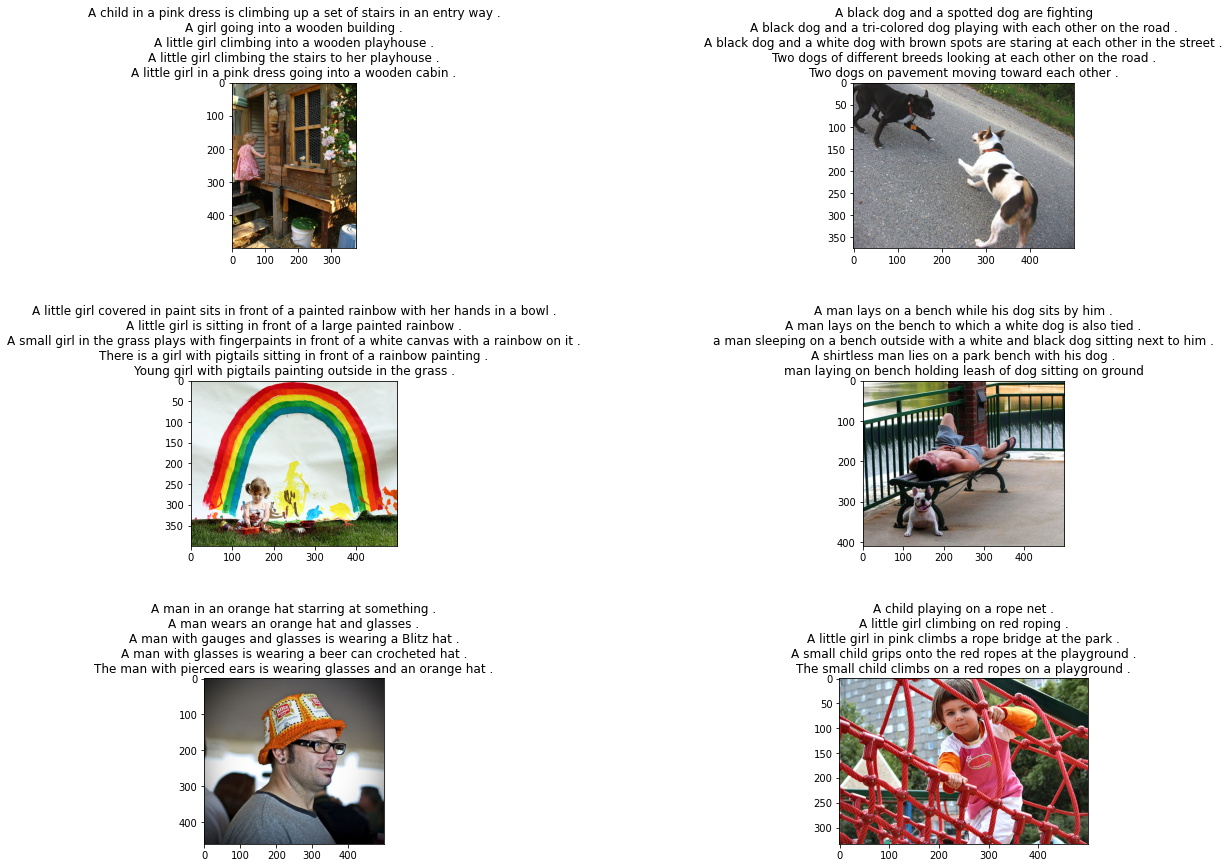

In [3]:
def show_sample_imeages(df, n=3, m=2):
    '''
    Visualises a number of images with the corresponding captions
    '''
    fig, axes = plt.subplots(n, m, figsize=(22,14))
    unique_files = df_caption.filename.unique()

    for i in range(n*m):
        filename = unique_files[i]
        caption = "\n".join(list(df.loc[df["filename"]==unique_files[i]]["text"]))
        img = mpimg.imread(image_path + filename)
        axes[i//m, i%m].imshow(img)
        axes[i//m, i%m].set_title(caption)
    plt.subplots_adjust(hspace = 0.8)
    plt.show()


show_sample_imeages(df_caption)

**Description:** We see the first six images from the dataset with their corresponding captions. The images have varying resolutions. The scenes contain people or animals performing a simple action. The captions in the dataset seem relatively clean at first glance. However, there are case-sensitive differences for individual words. In general, some editing will be necessary for the images and the captions, but the effort will probably not be too high.

### Average caption lengths

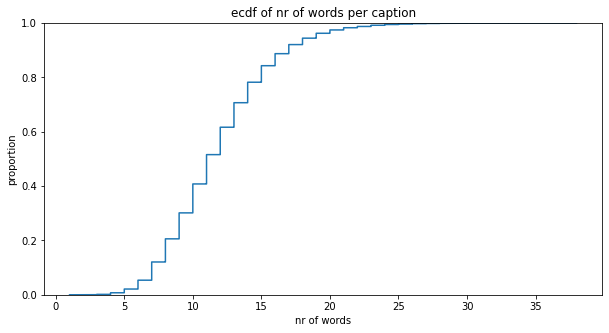

0.50    11.0
0.60    12.0
0.70    13.0
0.80    15.0
0.90    17.0
0.95    19.0
1.00    38.0
Name: text, dtype: float64

In [4]:
plt.figure(figsize=(10,5))
sns.ecdfplot(df_caption.text.apply(str.split).apply(len))
plt.title("ecdf of nr of words per caption")
plt.xlabel("nr of words")
plt.ylabel("proportion")
plt.show()

(df_caption.text.apply(str.split).apply(len)).quantile([.5,.6,.7,.8,.9,.95,1])

**Description:** The captions in the data set are a maximum of 38 words long. A word length of 19 would already be sufficient for over 95 percent of the captions.

### Image resolutions

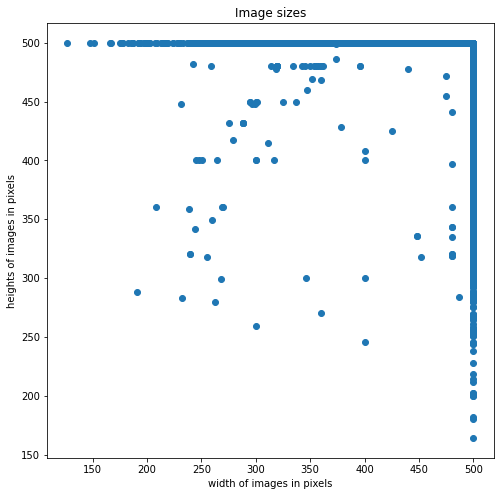

In [5]:
def plot_image_sizes(df):
    '''
    Visualizes the height and width of the images in nr of pixels.
    '''
    # read image sizes
    widths, heights = [], []
    for i in range(len(df)):
        filename = df.iloc[i]
        img = mpimg.imread(image_path + filename)
        width, heigth, chanels = np.shape(img)
        widths.append(width)
        heights.append(heigth)

    #create plot
    plt.figure(figsize=(8,8))
    plt.scatter(widths, heights)
    plt.title("Image sizes")
    plt.xlabel("width of images in pixels")
    plt.ylabel("heights of images in pixels")
    plt.show()

unique_filenames = df_caption["filename"].drop_duplicates()
plot_image_sizes(unique_filenames)

**Descriptions:** The visualisation shows the resolution of the images with their number of pixels in height and width. As already recognised in the visualised samples, the images vary in their resolution. However, a clear maximum boundary of 500 pixels is noticeable in the height and width over all images. For the CNN, it is necessary in our case that all images have the same resolution. For this reason, the images must be processed in a next step.

## Preprocessing 

### Preprocessing Images

This section handles the preprocessing of the images, which includes the following transformations: 
- `ToPILImage` Transformes the input images to a PIL image which provides the python interpreter with editing capabilities using the **P**ython **I**maging **L**ibrary.
- `CenterCrop` Crops the images from the center, resulting in a fixed image resolution.  In our case since the maximal resolution is 500 x 500 pixels, the images with less pixels recieve a padding of zeros to fill the gap.
- `Resize` Images to a resolution of 244 x 244 pixels which is the minimal input size for the Resnet18. Because we center croped all images to the same size before, a distortion of the images is avoided.
- `ToTensor` Trainforms the numpy format to a tensor.
- `Normalize` Normalizes the rgb channels of the dataset samples with the average values of the rgb channels.

In [6]:
from torchvision.transforms import Compose, CenterCrop, Resize, ToTensor, ToPILImage, Normalize

image_transform = Compose([
    ToPILImage(),
    CenterCrop((500, 500)),  # padd images
    Resize((224, 224)), # resnet18 minimal input shape
    ToTensor(),
    Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

# image_transform = Compose([
#     ToPILImage(),
#     CenterCrop((224, 224)), # resnet18 input shape
#     ToTensor(),
#     Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
#     ])

### Preprocessing Captions

In this section, the captions for the images are preprocessed. The captions are originally provided as strings. In a first step they are processed using the `basic_english` tokenizer included in the torchtext library. It performs several operations such as: lowercasing and replacing certain symbols using a pattern dict. We also limit the maximum number of words per caption to 20, since over 95 percent of all captions are within this range. Sentences with less than 20 words are padded using the `<pad>` token. Finally, we mark the beginning `<bos>` and end `<eos>` with the corresponding tokens, giving all captions a fixed length of 22 tokens.

In [7]:
# define special tokens
start_token = "<bos>"
stop_token = "<eos>"
unknown_token = "<unk>"
padding_token = "<pad>"

# define caption boundaries
max_length  = 20

# specify tokenizer
tokenizer = get_tokenizer('basic_english')

def preprocess_caption(text):
    '''
    Tokenizes the captions and applies preprocessing steps.
    '''
    # tokenize words with torchtext
    tokens = tokenizer(text)
    # cut list length to max_length
    tokens = tokens[:max_length]
    # add start and end token
    tokens = [start_token] + tokens + [stop_token]
    len_tokens = len(tokens)
    #pad to short sentences
    tokens = tokens + [padding_token] * (max_length + 2 - len(tokens))
    return tokens

def add_caption_lengths(text):
    return sum([x != "<pad>" for x in text])

df_caption["text_tokens"] = df_caption["text"].apply(preprocess_caption)

df_caption["caption_length"] = df_caption["text_tokens"].apply(add_caption_lengths) 

### Define Embedding 

Our network does not use the actual words from the captions in the dataset but takes features from an embedding as a vector representation. The aim of embedding is to transform the high dimensionality of the words into a vector space in a meaningful way. This space is significantly smaller in dimensionality, which makes the training more efficient. 
On one hand, it is necessary to define the vocabulary. On the other hand, it is required to create an embedding for the individual words with this vocabulary. There are two ways to do this. Firstly, it is possible to train an own embedding. The implementation is not too complicated, but since the embedding must also be trained, the learning curve of the network slows down significantly and can generally prevent from reaching the full potential of the predictions. The second option would be to use pre-trained word embedding vectors. An example of pre-trained word embedding would be by using [GloVe](https://nlp.stanford.edu/projects/glove/). 


Below we use the torchtext Vocab class to generate a onehot encoded vocabulary from the captions and read out the corresponding vectors from GloVe. In addition, the vocabulary is supplemented with our four keywords \<bos\>, \<eos\>, \<pad\> and \<unk\>. 

In [8]:
from collections import Counter, OrderedDict
from torchtext.vocab import Vocab, GloVe

#define embeding method
vectors = "glove.6B.100d"

# define minimal required occurence of words
min_word_count = 3

# count vocabulary
vocab_count = Counter()
for capiton in df_caption["text_tokens"]:
    vocab_count.update(capiton)
sorted_by_freq_tuples = sorted(vocab_count.items(), key=lambda x: x[1], reverse=True)
ordered_dict = OrderedDict(sorted_by_freq_tuples)

# define vocabulary
vocab = Vocab(
    vocab_count,
    vectors=vectors,  
    min_freq=min_word_count, 
    specials=((start_token, stop_token, unknown_token, padding_token)))

# comparison between vocabs
glove = GloVe(name='6B', dim=100)
print("GloVe vocab:", glove.vectors.size())

print("Reduced vocab:", vocab.vectors.size())

GloVe vocab: torch.Size([400000, 100])
Reduced vocab: torch.Size([4094, 100])


**Description:** We see that the raw glove embedding contains a vocabulary of 400,000 tokens. Our reduced vocabulary, on the other hand, has 4094 words, barely 1 percent of that.
For these words we now have the corresponding pre-trained embeding `vocab.vectors` which could be passed to the embedding layer in our later model.

#### Encoding of the dataframe

In [9]:
def encode_tokens(text):
    '''
    Encodes the tokens from string to integer using our vocabulary
    '''
    return [vocab.stoi[word] for word in text]

def inverse_encode_tokens(text):
    '''
    Encodes the tokens from integer to string using our vocabulary
    '''
    return [vocab.itos[word] for word in text]

text_list = ["<bos>", "Anton", "is", "in", "this", "picture", ":)", "<eos>"]

print("Input:", text_list )
embedded_text = encode_tokens(text_list)
print("Encoding:", embedded_text)
reconstructed_text = inverse_encode_tokens(embedded_text)
print("Inverse Encoding:", reconstructed_text)

Input: ['<bos>', 'Anton', 'is', 'in', 'this', 'picture', ':)', '<eos>']
Encoding: [0, 2, 9, 6, 333, 147, 2, 1]
Inverse Encoding: ['<bos>', '<unk>', 'is', 'in', 'this', 'picture', '<unk>', '<eos>']


**Description:** We see an example of how the encoding works. The special tokens \<bos\> and \<eos\> are correctly encoded and decoded again. Since "Anton" and ":)" do not occur in our generated vocabulary, they are encoded with the unknown token \<unk\>. So the encoding and decoding works. In a next step, we therefore apply the onehotencoding to the entire data set.

In [10]:
df_caption["text_encoded"] = df_caption["text_tokens"].apply(encode_tokens)
df_caption[["text", "text_tokens", "text_encoded"]].head()

,text,text_tokens,text_encoded
0,A child in a pink dress is climbing up a set o...,"[<bos>, a, child, in, a, pink, dress, is, clim...","[0, 4, 45, 6, 4, 94, 175, 9, 120, 56, 4, 406, ..."
1,A girl going into a wooden building .,"[<bos>, a, girl, going, into, a, wooden, build...","[0, 4, 21, 316, 67, 4, 200, 119, 5, 1, 3, 3, 3..."
2,A little girl climbing into a wooden playhouse .,"[<bos>, a, little, girl, climbing, into, a, wo...","[0, 4, 42, 21, 120, 67, 4, 200, 2574, 5, 1, 3,..."
3,A little girl climbing the stairs to her playh...,"[<bos>, a, little, girl, climbing, the, stairs...","[0, 4, 42, 21, 120, 7, 394, 23, 65, 2574, 5, 1..."
4,A little girl in a pink dress going into a woo...,"[<bos>, a, little, girl, in, a, pink, dress, g...","[0, 4, 42, 21, 6, 4, 94, 175, 316, 67, 4, 200,..."


### Train-test split 
For training, we divide the data set into a training set and a test set with a ratio of 4/1. Thereby it is relevant to make sure that all captions of a picture are in the same subset.

In [11]:
train_files, test_files = train_test_split(unique_filenames, test_size=0.2)
df_train = df_caption.loc[ df_caption["filename"].isin( list(train_files) )]
df_test = df_caption.loc[ df_caption["filename"].isin( list(test_files) )]


# save train and test split dataframes as pickles and load if already exists
if os.path.exists("./train.pickle") and os.path.exists("./test.pickle"):
    with open("./train.pickle", 'rb') as f:
        df_train =  pickle.load(f)
    with open("./test.pickle", 'rb') as f:
        df_test =  pickle.load(f)
else:
    with open("./train.pickle", 'wb') as f:
        pickle.dump(df_train, f, protocol=pickle.HIGHEST_PROTOCOL)
    with open("./test.pickle", 'wb') as f:
        pickle.dump(df_test, f, protocol=pickle.HIGHEST_PROTOCOL)


train_img_labels = set(df_train["filename"])
test_img_labels = set(df_test["filename"])
print("Proportion of train set:", len(train_img_labels) / (len(train_img_labels) + len(test_img_labels)))
print("Proportion of test set:", len(test_img_labels) / (len(train_img_labels) + len(test_img_labels)))
print("Overlapping labels of train and test set:", sum([label in train_img_labels for label in test_img_labels]))

Proportion of train set: 0.799901124706464
Proportion of test set: 0.20009887529353604
Overlapping labels of train and test set: 0


### Create train and test set

In [12]:
class Flickr8kDataset(Dataset):
    """
    Creates the dataset structure for training with pytorch
    Args:
        df (pandas DataFrame): contains the filenames and the captions of the pictures
        image_path (str): path to the image folder
        transform (callable, optional): Optional transform to apply on the images
        preload (bool): if true preloads the dataset to the memory
        """
    def __init__(self, df, image_path, transform=None, preload=False):
        
        self.df = df
        self.transform = transform
        self.preload = preload

        if self.preload:
            self.images = []
            for filename in tqdm(np.unique(df['filename'])):
                image = mpimg.imread(image_path + filename)
                if self.transform:
                    image = self.transform(image)
                self.images.append(image)

            self.df['image_idx'] = df.groupby('filename').ngroup()

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        df_row = self.df.iloc[idx, :]

        if self.preload:
            image_id = self.df.iloc[idx]['image_idx']
            image = self.images[image_id]
        else:
            image = mpimg.imread(image_path + df_row['filename'])
            if self.transform:
                image = self.transform(image)

        caption = torch.from_numpy(np.array(df_row['text_encoded']))
        length = torch.from_numpy(np.array(df_row['caption_length']))
        return image, caption, length
        


In [13]:
train_set = Flickr8kDataset(df_train, image_path, transform=image_transform, preload=True)
test_set = Flickr8kDataset(df_test, image_path, transform=image_transform, preload=True)

100%|██████████| 1619/1619 [00:10<00:00, 148.28it/s]


### Define the dataloader

In [14]:
# Set seed 
torch.manual_seed(42)
batch_size = 64

train_dataloader = DataLoader(
    dataset=train_set, 
    batch_size=batch_size, 
    shuffle=True)

test_dataloader = DataLoader(
    dataset=test_set, 
    batch_size=batch_size, 
    shuffle=False)

In [15]:
example_batch = iter(train_dataloader)
samples, labels, length = example_batch.next()
np.shape(labels)

torch.Size([64, 22])

### Model Structure

The `EncoderCNN` model consists of two main components: The image is fed into a deep Convolutional Neural Network (CNN). This generates a vector representation, which is extracted from the last hidden layer. The resulting vector is then used as feature input of the `DecoderRNN`, which contains a a Long Short Term Memory (LSTM) to generate the sentence structure.

#### CNN
For the CNN, we use the pytorch libaray [Restnet18](https://pytorch.org/hub/pytorch_vision_resnet/) model which has been pre-trained on the ImageNet dataset on a image classification task of 1000 classes. In general, it would also be possible to use any other CNN structure for this task. To be able to use the network for our captioning task, the last hidden layer has to be manually modified and trainied using transfer learning to match the feature vectors on the embedding layer. Therefore the output of the linear layer has to match the dimensions of the embedding layer vectors for the subsequent LSTM network.


#### LSTM
The LSTM is now used to decode the feature vector. While training, it receives as input a `PackedSequence` consisting of the concatenation of the feature vectors and the embedding. This enables the network to recieve inouts of varying lengths. The output of the LSTM is then transformed back into the vocab_size dimension by an additional linear layer. In this way, the linear layer serves as reverse encoding, whereby the output represents the weights for the assignment to the words in our vocabulary.

Due to the additional "packing" of the labels using pytorchs `pack_padded_sequence` method, we gain the advantage that the \<pad\> tokens are not included in the cost function when calculating the crossentropy loss.

During training, the LSTM receives as inputs the tokens that were generated on the original captions. The output of the LSTM is ignored in this stage. If instead the generated output from the last iteration were used as input, the predictions of the LSTM in the later iterations of a sequence would be very strongly dependent on the previously generated output. The network would train on assumptions that are often incorrect, especially at the beginning of the training, and would therefore slow down the training of the network.

When predicting with the trained network, no captions are included, so the highest probability token from the output of the previous iteration is used as input for the next iteration of the LSTM.

#### Combination

Both model classes are integrated into a single `CNNtoRNN` class. This is primarily for structural reasons and allows to call the functionalities of both models in a combined class structure. Additionally, the function for captioning a single image is integrated here.


### Define models

In [16]:
class EncoderCNN(nn.Module):
    '''
    The Encoder class
    Args:
        embed_size (int)
        train_cnn (bool) if true trains the complete network
    '''
    def __init__(self, embed_size, train_cnn=False):
        super(EncoderCNN, self).__init__()
        self.train_cnn = train_cnn
        self.cnn_model = models.resnet18(pretrained=True)
        self.cnn_model.fc = nn.Linear(self.cnn_model.fc.in_features, embed_size) # resize outout shape
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm1d(embed_size)

    def forward(self, images):
        features = self.cnn_model(images)

        # specify if the complete network should be trained or only the last one
        for name, param in self.cnn_model.named_parameters():
            if "fc.weight" in name or "fc.bias" in name:
                param.requires_grad = True
            else:
                param.requires_grad = self.train_cnn
        return self.bn(self.relu(features))



class DecoderRNN(nn.Module):
    '''
    The decoder class
    Args:
        embed_size (int): size of the embeddings
        hidden_size (int): equal to embed size
        vocab_size (int): equals the number of words in the vocab
        num_layers (int): number of layers in the lstm
        dropout (float): dropout ratio for the embeddings
        pretrained_emb (bool): if true uses the pretrained glove embedding vectors
    '''
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, dropout=0, pretrained_emb=False):
        super(DecoderRNN, self).__init__()
        if pretrained_emb:
            self.embedding = nn.Embedding.from_pretrained(vocab.vectors, freeze=True)
        else:
            self.embedding = nn.Embedding(vocab_size, embed_size) # ????????????????
        
        self.lstm = nn.LSTM(input_size=embed_size, 
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            # batch_first=True
                            )
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout)
        

    def forward(self, features, captions, lengths):
        # print("captions shape", np.shape(captions))
        # embedding of captions
        embeddings = self.dropout(self.embedding(captions))
        # print("Embedded captions shape", np.shape(embeddings))
        # print("features shape", np.shape(features))
        embeddings = torch.cat((features.unsqueeze(1), embeddings), dim=1)
        packed = pack_padded_sequence(embeddings, lengths, enforce_sorted=False, batch_first=True)

        output_packed, hidden = self.lstm(packed) #(1, batch size, len_embedding)
        output_padded, output_lengths = pad_packed_sequence(output_packed, batch_first=True)
        
        outputs = self.linear(output_padded)
        return outputs



class CNNtoRNN(nn.Module):

    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, dropout=0, pretrained_emb=False):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size=embed_size)
        self.decoderRNN = DecoderRNN(embed_size=embed_size, hidden_size=hidden_size, vocab_size=vocab_size, num_layers=num_layers, pretrained_emb=pretrained_emb)

    def forward(self, images, capitons, lengths):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, capitons, lengths)
        return outputs

    def caption_images(self, image, vocabulary, max_length = 30):
        '''Creates a caption for a single image'''
        caption_result = []
        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None
       
            for _ in range(max_length):
                hidden, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hidden.squeeze(0))
                predicted = output.argmax(1)

                caption_result.append(predicted.item())
                x = self.decoderRNN.embedding(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "<eos>":
                    break
            return "".join([vocabulary.itos[idx] + " " for idx in caption_result])



def caption_image(model, path=image_path, filename=None, transform=image_transform):
    '''
    Creates a caption for a single image
    Args:
        model (CNNtoRNN): model class
        path (str): path to image folder
        filename (str): name of image, if None a random image is selected
        transform (torchvision.transforms.Compose): the transformations of the image before feeding into the model
    '''
    model.eval()
    if not filename:
        filename = random.choice(os.listdir(path))
    image = mpimg.imread(path + filename)
    if transform is not None:
        image_tensor = transform(image)
    with torch.no_grad():
        image_tensor = (image_tensor[None, ...]).to(device)
        return filename, image, model.caption_images(image_tensor, vocab)  

def func_save_model(model, path, name):
        '''
        Saves the model as state dict.
        Args:
            model (CNNtoRNN): the model class
            path (str): path where to save the model
            name of the document
        '''
        filename = "{}.pt".format(name)
        print(filename)
        if not os.path.exists(path):
            os.makedirs(path)
        torch.save(model, path + filename)

def func_save_log(log_dict, name):
    '''
    Saves the logging dictionary as pickle object
    Args: 
        log_dict (dict): contains the logged metricts from the training
        name (str): the name of the pickle file
    '''
    with open('{}.pickle'.format(name), 'wb') as f:
        pickle.dump(log_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

def func_open_log(name):
    '''
    Opens the logging dictionary from a pickle object
    Args: 
        name (str): the name of the pickle file
    Returns: 
        log_dict (dict): contains the logged metricts from the training
    '''
    with open('{}.pickle'.format(name), 'rb') as f:
        return pickle.load(f)


In [34]:
import torch.optim as optim
from tqdm import tqdm
from torch.nn.utils.rnn import pack_padded_sequence
import pickle
import wandb

run_cell = True
# wandb
use_wandb = True
# model loading & saving
load_model = False
save_model = True
model_path = "./saved_models/"
model_name = "untrained_embedding"
# training hyperparameters
pretrained_emb = False
embed_size = 100
hidden_size = 100
vocab_size = vocab.vectors.size()[0]
num_layers = 1
learning_rate = 0.003
num_epochs=200
# BLEU evaluation
include_bleu_test_score = True
n_samples = 128 # nr of random samples for BLEU score


if run_cell:
    # define training modules
    if load_model:
        log_dict = func_open_log(model_name)
        step = log_dict[max(int(k) for k in log_dict.keys())]["step"]
        model = torch.load(model_path + "{}_e{}.pt".format(model_name, len(log_dict)), map_location=device)
    else: 
        log_dict = dict()
        step = 0
        model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers, pretrained_emb).to(device)

    criterion = nn.CrossEntropyLoss() # ignore_index
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    if use_wandb:
        wandb.init(reinit=True, project="del_mc2", entity="simonluder")


    for epoch in range(len(log_dict)+1,len(log_dict)+1+num_epochs):
        print("epoch:", epoch)
        cumloss = 0

        model.train()
        for i, (imgs, captions, lengths) in tqdm(enumerate(train_dataloader)):
            
            step += len(imgs)
            # print(np.shape(imgs), np.shape(captions))
            imgs = imgs.to(device)
            captions = captions.to(device)
            # targets = pack_padded_sequence(captions, length, batch_first=True)[0]

            packed_captions = pack_padded_sequence(captions, lengths, enforce_sorted=False, batch_first=True)[0]
            # print(targets)
            outputs = model(imgs, captions[:,:-1], lengths)
            packed_outputs = pack_padded_sequence(outputs, lengths, enforce_sorted=False, batch_first=True)[0]
            # print("packed_captions", np.shape(packed_captions))
            # print("packed_outputs", np.shape(packed_outputs))
            
            # print(np.shape(captions.reshape(-1)))
            # # outputs = pack_padded_sequence(outputs, lengths.tolist(), enforce_sorted=False, batch_first=True)[0]
            # print(np.shape(outputs.reshape(-1, outputs.shape[2])))
            # print(np.shape(targets))
            # # loss = criterion(outputs, targets)
            # loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1).type(torch.long))
            loss = criterion(packed_outputs, packed_captions.type(torch.long))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            cumloss += loss.item()

            if i % 10 == 0 and use_wandb:
                wandb.log({
                    "model":model_name,
                    "train_loss": loss,
                    "epoch":epoch+1, 
                    }, step=step)

        model.eval()   
        # calculate BLEU
        if include_bleu_test_score:
            mean_bleu = 0
            for j, file in enumerate(random.sample(list(set(df_test["filename"])), n_samples)):
                (file, _, caption) = caption_image(model)
                train_captions = df_caption.loc[df_caption["filename"]==file]["text"].apply(str.split).to_list()
                mean_bleu += sentence_bleu(train_captions, caption.split()[1:-1])
            mean_bleu /= n_samples

            
        log_dict[epoch] = {
            "step":step, 
            "train_loss":cumloss,
            "test_bleu":mean_bleu
            }

        # save the model at the end of the epoch
        func_save_model(model, model_path, "{}_e{}".format(model_name, epoch))
        func_save_log(log_dict, model_name)


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,▃▅▂▇▅▄▄▅▆▁▁▆▆▄▄▃▂▄▇▄▃▃▅▄▆▃▃▆█▃▆▇▄▅▆▅█▆▅▆
epoch,201
model,pretrained_embedding...
train_loss,1.45334


epoch: 1


506it [01:00,  8.37it/s]


untrained_embedding_e1.pt
epoch: 2


506it [01:00,  8.39it/s]


untrained_embedding_e2.pt
epoch: 3


506it [01:00,  8.32it/s]


untrained_embedding_e3.pt
epoch: 4


506it [01:00,  8.35it/s]


untrained_embedding_e4.pt
epoch: 5


506it [01:01,  8.28it/s]


untrained_embedding_e5.pt
epoch: 6


506it [01:00,  8.36it/s]


untrained_embedding_e6.pt
epoch: 7


506it [00:59,  8.51it/s]


untrained_embedding_e7.pt
epoch: 8


506it [00:59,  8.49it/s]


untrained_embedding_e8.pt
epoch: 9


506it [00:59,  8.53it/s]


untrained_embedding_e9.pt
epoch: 10


506it [00:59,  8.54it/s]


untrained_embedding_e10.pt
epoch: 11


506it [00:59,  8.54it/s]


untrained_embedding_e11.pt
epoch: 12


506it [00:59,  8.54it/s]


untrained_embedding_e12.pt
epoch: 13


506it [00:59,  8.54it/s]


untrained_embedding_e13.pt
epoch: 14


506it [00:59,  8.56it/s]


untrained_embedding_e14.pt
epoch: 15


506it [00:59,  8.54it/s]


untrained_embedding_e15.pt
epoch: 16


506it [00:59,  8.54it/s]


untrained_embedding_e16.pt
epoch: 17


506it [00:58,  8.59it/s]


untrained_embedding_e17.pt
epoch: 18


506it [00:56,  8.97it/s]


untrained_embedding_e18.pt
epoch: 19


506it [00:56,  8.98it/s]


untrained_embedding_e19.pt
epoch: 20


506it [00:56,  8.96it/s]


untrained_embedding_e20.pt
epoch: 21


506it [00:56,  8.96it/s]


untrained_embedding_e21.pt
epoch: 22


506it [00:57,  8.75it/s]


untrained_embedding_e22.pt
epoch: 23


506it [00:58,  8.72it/s]


untrained_embedding_e23.pt
epoch: 24


506it [00:57,  8.73it/s]


untrained_embedding_e24.pt
epoch: 25


506it [00:57,  8.74it/s]


untrained_embedding_e25.pt
epoch: 26


506it [00:56,  8.95it/s]


untrained_embedding_e26.pt
epoch: 27


506it [00:56,  8.96it/s]


untrained_embedding_e27.pt
epoch: 28


506it [00:56,  8.98it/s]


untrained_embedding_e28.pt
epoch: 29


506it [00:56,  9.02it/s]


untrained_embedding_e29.pt
epoch: 30


506it [00:56,  8.99it/s]


untrained_embedding_e30.pt
epoch: 31


506it [00:56,  8.97it/s]


untrained_embedding_e31.pt
epoch: 32


506it [00:56,  8.99it/s]


untrained_embedding_e32.pt
epoch: 33


506it [00:56,  8.99it/s]


untrained_embedding_e33.pt
epoch: 34


506it [00:56,  8.96it/s]


untrained_embedding_e34.pt
epoch: 35


506it [00:56,  8.97it/s]


untrained_embedding_e35.pt
epoch: 36


506it [00:56,  8.97it/s]


untrained_embedding_e36.pt
epoch: 37


506it [00:56,  8.94it/s]


untrained_embedding_e37.pt
epoch: 38


506it [00:56,  8.94it/s]


untrained_embedding_e38.pt
epoch: 39


506it [00:56,  8.94it/s]


untrained_embedding_e39.pt
epoch: 40


506it [00:56,  8.94it/s]


untrained_embedding_e40.pt
epoch: 41


506it [00:56,  8.95it/s]


untrained_embedding_e41.pt
epoch: 42


506it [00:56,  8.95it/s]


untrained_embedding_e42.pt
epoch: 43


506it [00:56,  8.94it/s]


untrained_embedding_e43.pt
epoch: 44


506it [00:56,  8.95it/s]


untrained_embedding_e44.pt
epoch: 45


506it [00:56,  8.95it/s]


untrained_embedding_e45.pt
epoch: 46


506it [00:56,  8.96it/s]


untrained_embedding_e46.pt
epoch: 47


506it [00:56,  8.94it/s]


untrained_embedding_e47.pt
epoch: 48


506it [00:56,  8.94it/s]


untrained_embedding_e48.pt
epoch: 49


506it [00:56,  8.93it/s]


untrained_embedding_e49.pt
epoch: 50


506it [00:57,  8.74it/s]


untrained_embedding_e50.pt
epoch: 51


506it [00:56,  8.95it/s]


untrained_embedding_e51.pt
epoch: 52


506it [00:56,  8.94it/s]


untrained_embedding_e52.pt
epoch: 53


506it [00:56,  8.94it/s]


untrained_embedding_e53.pt
epoch: 54


506it [00:57,  8.77it/s]


untrained_embedding_e54.pt
epoch: 55


506it [00:57,  8.73it/s]


untrained_embedding_e55.pt
epoch: 56


506it [00:57,  8.74it/s]


untrained_embedding_e56.pt
epoch: 57


506it [00:57,  8.75it/s]


untrained_embedding_e57.pt
epoch: 58


506it [00:57,  8.75it/s]


untrained_embedding_e58.pt
epoch: 59


506it [00:57,  8.75it/s]


untrained_embedding_e59.pt
epoch: 60


506it [00:57,  8.75it/s]


untrained_embedding_e60.pt
epoch: 61


506it [00:57,  8.76it/s]


untrained_embedding_e61.pt
epoch: 62


506it [00:57,  8.75it/s]


untrained_embedding_e62.pt
epoch: 63


506it [00:57,  8.76it/s]


untrained_embedding_e63.pt
epoch: 64


506it [00:57,  8.75it/s]


untrained_embedding_e64.pt
epoch: 65


506it [00:58,  8.71it/s]


untrained_embedding_e65.pt
epoch: 66


506it [00:57,  8.77it/s]


untrained_embedding_e66.pt
epoch: 67


506it [00:57,  8.73it/s]


untrained_embedding_e67.pt
epoch: 68


506it [00:57,  8.74it/s]


untrained_embedding_e68.pt
epoch: 69


506it [00:58,  8.71it/s]


untrained_embedding_e69.pt
epoch: 70


506it [00:56,  8.96it/s]


untrained_embedding_e70.pt
epoch: 71


506it [00:56,  8.98it/s]


untrained_embedding_e71.pt
epoch: 72


506it [00:56,  8.99it/s]


untrained_embedding_e72.pt
epoch: 73


506it [00:56,  8.98it/s]


untrained_embedding_e73.pt
epoch: 74


506it [00:56,  8.99it/s]


untrained_embedding_e74.pt
epoch: 75


506it [00:56,  8.99it/s]


untrained_embedding_e75.pt
epoch: 76


506it [00:56,  8.99it/s]


untrained_embedding_e76.pt
epoch: 77


506it [00:56,  8.99it/s]


untrained_embedding_e77.pt
epoch: 78


506it [00:56,  8.97it/s]


untrained_embedding_e78.pt
epoch: 79


506it [00:56,  8.97it/s]


untrained_embedding_e79.pt
epoch: 80


506it [00:56,  8.99it/s]


untrained_embedding_e80.pt
epoch: 81


506it [00:56,  8.98it/s]


untrained_embedding_e81.pt
epoch: 82


506it [00:56,  8.98it/s]


untrained_embedding_e82.pt
epoch: 83


506it [00:56,  8.97it/s]


untrained_embedding_e83.pt
epoch: 84


506it [00:56,  8.98it/s]


untrained_embedding_e84.pt
epoch: 85


506it [00:56,  8.98it/s]


untrained_embedding_e85.pt
epoch: 86


506it [00:56,  8.98it/s]


untrained_embedding_e86.pt
epoch: 87


506it [00:56,  8.99it/s]


untrained_embedding_e87.pt
epoch: 88


506it [00:56,  8.97it/s]


untrained_embedding_e88.pt
epoch: 89


506it [00:56,  8.99it/s]


untrained_embedding_e89.pt
epoch: 90


506it [00:56,  8.98it/s]


untrained_embedding_e90.pt
epoch: 91


506it [00:56,  8.98it/s]


untrained_embedding_e91.pt
epoch: 92


506it [00:56,  8.97it/s]


untrained_embedding_e92.pt
epoch: 93


506it [00:56,  8.98it/s]


untrained_embedding_e93.pt
epoch: 94


506it [00:56,  8.96it/s]


untrained_embedding_e94.pt
epoch: 95


506it [00:56,  8.96it/s]


untrained_embedding_e95.pt
epoch: 96


506it [00:56,  8.98it/s]


untrained_embedding_e96.pt
epoch: 97


506it [00:56,  8.98it/s]


untrained_embedding_e97.pt
epoch: 98


506it [00:56,  8.97it/s]


untrained_embedding_e98.pt
epoch: 99


506it [00:56,  8.98it/s]


untrained_embedding_e99.pt
epoch: 100


506it [00:56,  8.97it/s]


untrained_embedding_e100.pt
epoch: 101


506it [00:56,  8.96it/s]


untrained_embedding_e101.pt
epoch: 102


506it [00:56,  8.97it/s]


untrained_embedding_e102.pt
epoch: 103


506it [00:56,  8.97it/s]


untrained_embedding_e103.pt
epoch: 104


506it [00:56,  8.97it/s]


untrained_embedding_e104.pt
epoch: 105


506it [00:56,  8.97it/s]


untrained_embedding_e105.pt
epoch: 106


506it [00:56,  8.97it/s]


untrained_embedding_e106.pt
epoch: 107


506it [00:56,  8.97it/s]


untrained_embedding_e107.pt
epoch: 108


506it [00:56,  8.96it/s]


untrained_embedding_e108.pt
epoch: 109


506it [00:57,  8.86it/s]


untrained_embedding_e109.pt
epoch: 110


506it [00:57,  8.77it/s]


untrained_embedding_e110.pt
epoch: 111


506it [00:56,  8.98it/s]


untrained_embedding_e111.pt
epoch: 112


506it [00:56,  8.96it/s]


untrained_embedding_e112.pt
epoch: 113


506it [00:56,  8.97it/s]


untrained_embedding_e113.pt
epoch: 114


506it [00:56,  8.96it/s]


untrained_embedding_e114.pt
epoch: 115


506it [00:56,  8.96it/s]


untrained_embedding_e115.pt
epoch: 116


506it [00:56,  8.97it/s]


untrained_embedding_e116.pt
epoch: 117


506it [00:56,  8.96it/s]


untrained_embedding_e117.pt
epoch: 118


506it [00:56,  8.97it/s]


untrained_embedding_e118.pt
epoch: 119


506it [00:56,  8.96it/s]


untrained_embedding_e119.pt
epoch: 120


506it [00:56,  8.97it/s]


untrained_embedding_e120.pt
epoch: 121


506it [00:56,  8.96it/s]


untrained_embedding_e121.pt
epoch: 122


506it [00:56,  8.97it/s]


untrained_embedding_e122.pt
epoch: 123


506it [00:56,  8.96it/s]


untrained_embedding_e123.pt
epoch: 124


506it [00:56,  8.92it/s]


untrained_embedding_e124.pt
epoch: 125


506it [00:56,  8.96it/s]


untrained_embedding_e125.pt
epoch: 126


506it [00:56,  8.97it/s]


untrained_embedding_e126.pt
epoch: 127


506it [00:56,  8.94it/s]


untrained_embedding_e127.pt
epoch: 128


506it [00:56,  8.98it/s]


untrained_embedding_e128.pt
epoch: 129


506it [00:56,  8.97it/s]


untrained_embedding_e129.pt
epoch: 130


506it [00:56,  8.98it/s]


untrained_embedding_e130.pt
epoch: 131


506it [00:56,  8.95it/s]


untrained_embedding_e131.pt
epoch: 132


506it [00:56,  8.95it/s]


untrained_embedding_e132.pt
epoch: 133


506it [00:56,  8.93it/s]


untrained_embedding_e133.pt
epoch: 134


506it [00:56,  8.93it/s]


untrained_embedding_e134.pt
epoch: 135


506it [00:56,  8.94it/s]


untrained_embedding_e135.pt
epoch: 136


506it [00:56,  8.93it/s]


untrained_embedding_e136.pt
epoch: 137


506it [00:57,  8.79it/s]


untrained_embedding_e137.pt
epoch: 138


506it [00:57,  8.74it/s]


untrained_embedding_e138.pt
epoch: 139


506it [00:57,  8.74it/s]


untrained_embedding_e139.pt
epoch: 140


506it [00:57,  8.73it/s]


untrained_embedding_e140.pt
epoch: 141


506it [00:57,  8.84it/s]


untrained_embedding_e141.pt
epoch: 142


506it [00:57,  8.80it/s]


untrained_embedding_e142.pt
epoch: 143


506it [00:58,  8.71it/s]


untrained_embedding_e143.pt
epoch: 144


506it [00:57,  8.73it/s]


untrained_embedding_e144.pt
epoch: 145


506it [00:57,  8.73it/s]


untrained_embedding_e145.pt
epoch: 146


506it [00:57,  8.76it/s]


untrained_embedding_e146.pt
epoch: 147


506it [00:58,  8.72it/s]


untrained_embedding_e147.pt
epoch: 148


506it [00:57,  8.76it/s]


untrained_embedding_e148.pt
epoch: 149


506it [00:57,  8.74it/s]


untrained_embedding_e149.pt
epoch: 150


506it [00:57,  8.73it/s]


untrained_embedding_e150.pt
epoch: 151


506it [00:57,  8.75it/s]


untrained_embedding_e151.pt
epoch: 152


506it [00:57,  8.74it/s]


untrained_embedding_e152.pt
epoch: 153


506it [00:57,  8.74it/s]


untrained_embedding_e153.pt
epoch: 154


506it [00:57,  8.74it/s]


untrained_embedding_e154.pt
epoch: 155


506it [00:56,  8.93it/s]


untrained_embedding_e155.pt
epoch: 156


506it [00:57,  8.77it/s]


untrained_embedding_e156.pt
epoch: 157


506it [00:57,  8.77it/s]


untrained_embedding_e157.pt
epoch: 158


506it [00:57,  8.79it/s]


untrained_embedding_e158.pt
epoch: 159


506it [00:57,  8.73it/s]


untrained_embedding_e159.pt
epoch: 160


506it [00:57,  8.75it/s]


untrained_embedding_e160.pt
epoch: 161


506it [00:57,  8.75it/s]


untrained_embedding_e161.pt
epoch: 162


506it [00:57,  8.77it/s]


untrained_embedding_e162.pt
epoch: 163


506it [00:57,  8.73it/s]


untrained_embedding_e163.pt
epoch: 164


506it [00:57,  8.77it/s]


untrained_embedding_e164.pt
epoch: 165


506it [00:57,  8.76it/s]


untrained_embedding_e165.pt
epoch: 166


506it [00:58,  8.71it/s]


untrained_embedding_e166.pt
epoch: 167


506it [00:57,  8.75it/s]


untrained_embedding_e167.pt
epoch: 168


506it [00:58,  8.72it/s]


untrained_embedding_e168.pt
epoch: 169


506it [00:57,  8.75it/s]


untrained_embedding_e169.pt
epoch: 170


506it [00:58,  8.71it/s]


untrained_embedding_e170.pt
epoch: 171


506it [00:58,  8.72it/s]


untrained_embedding_e171.pt
epoch: 172


506it [00:57,  8.73it/s]


untrained_embedding_e172.pt
epoch: 173


506it [00:58,  8.72it/s]


untrained_embedding_e173.pt
epoch: 174


506it [00:58,  8.72it/s]


untrained_embedding_e174.pt
epoch: 175


506it [00:57,  8.73it/s]


untrained_embedding_e175.pt
epoch: 176


506it [00:57,  8.75it/s]


untrained_embedding_e176.pt
epoch: 177


506it [00:57,  8.73it/s]


untrained_embedding_e177.pt
epoch: 178


506it [00:57,  8.76it/s]


untrained_embedding_e178.pt
epoch: 179


506it [00:57,  8.74it/s]


untrained_embedding_e179.pt
epoch: 180


506it [00:57,  8.73it/s]


untrained_embedding_e180.pt
epoch: 181


506it [00:57,  8.74it/s]


untrained_embedding_e181.pt
epoch: 182


506it [00:57,  8.76it/s]


untrained_embedding_e182.pt
epoch: 183


506it [00:58,  8.72it/s]


untrained_embedding_e183.pt
epoch: 184


506it [00:57,  8.79it/s]


untrained_embedding_e184.pt
epoch: 185


506it [00:57,  8.75it/s]


untrained_embedding_e185.pt
epoch: 186


506it [00:57,  8.77it/s]


untrained_embedding_e186.pt
epoch: 187


506it [00:57,  8.74it/s]


untrained_embedding_e187.pt
epoch: 188


506it [00:57,  8.74it/s]


untrained_embedding_e188.pt
epoch: 189


506it [00:57,  8.74it/s]


untrained_embedding_e189.pt
epoch: 190


506it [00:57,  8.73it/s]


untrained_embedding_e190.pt
epoch: 191


506it [00:57,  8.77it/s]


untrained_embedding_e191.pt
epoch: 192


506it [00:57,  8.78it/s]


untrained_embedding_e192.pt
epoch: 193


506it [00:57,  8.79it/s]


untrained_embedding_e193.pt
epoch: 194


506it [00:57,  8.76it/s]


untrained_embedding_e194.pt
epoch: 195


506it [00:58,  8.72it/s]


untrained_embedding_e195.pt
epoch: 196


506it [00:57,  8.80it/s]


untrained_embedding_e196.pt
epoch: 197


506it [00:58,  8.70it/s]


untrained_embedding_e197.pt
epoch: 198


506it [00:57,  8.77it/s]


untrained_embedding_e198.pt
epoch: 199


506it [00:58,  8.72it/s]


untrained_embedding_e199.pt
epoch: 200


506it [00:57,  8.74it/s]


untrained_embedding_e200.pt


## Evaluation

### Visualizing Loss of the train set

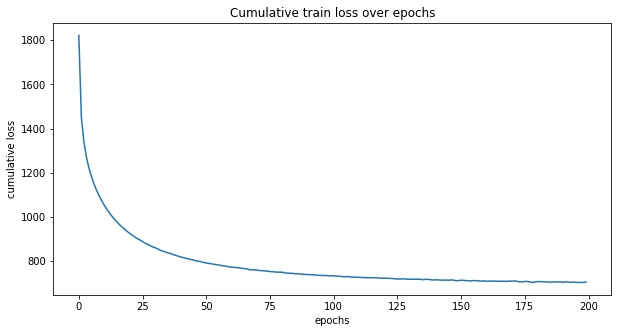

In [37]:
model_name = "untrained_embedding"
log_dict = func_open_log(model_name)
test_bleu = []
epochs = []
train_losses = []

for i in range(1, len(log_dict)+1):
    test_bleu.append(log_dict[i]["test_bleu"])
    epochs.append(i)
    train_losses.append(log_dict[i]["train_loss"])

plt.figure(figsize=(10,5))
plt.plot(train_losses)
plt.title("Cumulative train loss over epochs")
plt.xlabel("epochs")
plt.ylabel("cumulative loss")
plt.show()

In [21]:
model_path = "./saved_models/"
model_name = "pretrained_embedding"
epochs_trained = 40

def eval_caption(model, filename=None):
    (file, image, caption) = caption_image(model, filename=filename)

    caption.split()[1:-1]
    train_captions = df_caption.loc[df_caption["filename"]==file]["text"].apply(str.split).to_list()

    bleu =  sentence_bleu(train_captions, caption.split()[1:-1], weights=(1/2, 1/2))
    return file, bleu

model = torch.load(model_path + "{}_e{}.pt".format(model_name, epochs_trained), map_location=device)
df_bleu_scores = pd.DataFrame(columns=["filename", "bleu_score", "set"])

for f in tqdm(set(df_test["filename"])):
    (file, bleu) = (eval_caption(model, filename=f))
    df_bleu_scores.loc[len(df_bleu_scores.index)] = [file, bleu, "test"]

for f in tqdm(set(df_train["filename"])):
    (file, bleu) = (eval_caption(model, filename=f))
    df_bleu_scores.loc[len(df_bleu_scores.index)] = [file, bleu, "train"]


100%|██████████| 6472/6472 [02:56<00:00, 36.69it/s]


### Comparison of bleu scores for train and test set

In [22]:
def plot_bleu_distribution(scores, title):
    '''Creates a histogramm of the bleu scores'''
    plt.figure(figsize=(10, 5))
    plt.hist(scores, bins=25)
    plt.title(title)
    plt.xlabel("BLEU score")
    plt.ylabel("nr of samples")
    plt.show()

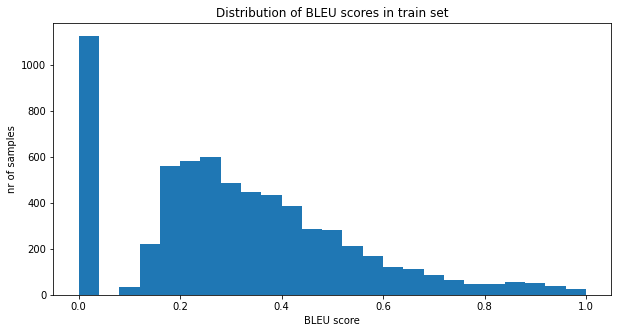

BLEU scores quantiles for train set:
 0.00    0.000
0.25    0.179
0.50    0.296
0.75    0.437
1.00    1.000
Name: bleu_score, dtype: float64


In [23]:
plot_bleu_distribution(df_bleu_scores.loc[df_bleu_scores["set"]=="train"]["bleu_score"], title = "Distribution of BLEU scores in train set" )
print("BLEU scores quantiles for train set:\n", df_bleu_scores.loc[df_bleu_scores["set"]=="train"]["bleu_score"].quantile([0,.25,.5,.75,1]).round(3))

**Description:**  The histogram shows the distribution of the achieved BLEU score scale for all samples from the training set. We see that the BLEU scores are distributed over the entire value scale with a concentration around 0.33. There are several captions with very good BLEU scores greater than 0.8. Also there are many samples which have achieved a BLEU score of 0. Subsequently, we now want to make a comparison of the BLEU scores for the test set.

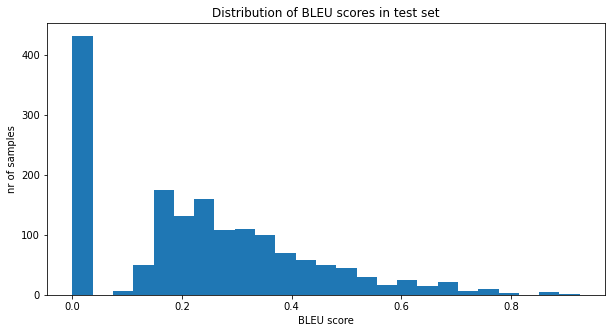

BLEU scores quantiles for test set:
 0.00    0.000
0.25    0.000
0.50    0.227
0.75    0.348
1.00    0.926
Name: bleu_score, dtype: float64


In [24]:
plot_bleu_distribution(df_bleu_scores.loc[df_bleu_scores["set"]=="test"]["bleu_score"], title = "Distribution of BLEU scores in test set" )
print("BLEU scores quantiles for test set:\n", df_bleu_scores.loc[df_bleu_scores["set"]=="test"]["bleu_score"].quantile([0,.25,.5,.75,1]).round(3))

**Description:**  The histogram shows the distribution of the achieved BLEU score scale for all samples from the test set. We see that there are significantly more images in the dataset that received a BLEU score of 0. Also, there are almost no images in the value range 0.6 upwards. This might be because of several reasons. On the one hand, a minimal deterioration if the average BLEU Score can be expected due to variance in sentence structures. Also, the test set contains words and objects that were not used in the training. Thus, the model is sometimes not able to recognise these objects at all. 

### Visualizing single examples

Now we will take a closer look at a handful of examples with very good and very bad BLEU Scores from the test set.

In [25]:
df_bleu_scores_test = df_bleu_scores.loc[df_bleu_scores["set"]=="test"]
df_bleu_scores_test = df_bleu_scores_test.sort_values("bleu_score", ascending=False).reset_index(drop=True)

def sample_presentation(model, filename):
    '''Shows an Image with corresponging caption, bleu score and ranking compared to the other samples in the test set'''
    (file, image, caption) = caption_image(model, filename = filename)
    plt.imshow(image)
    plt.show()
    print("Captioning image: {}".format(file))  
    print("Caption sencence:", caption)
    caption.split()[1:-1]
    train_captions = df_caption.loc[df_caption["filename"]==file]["text"].apply(str.split).to_list()
    bleu =  sentence_bleu(train_captions, caption.split()[1:-1], weights=(1/2, 1/2))
    print("BLEU score:",bleu)
    print("Ranking in test set according to BLEU score:", int(df_bleu_scores_test.loc[df_bleu_scores_test["filename"] == file].index.values), "of", len(df_bleu_scores_test))

#### Good captions

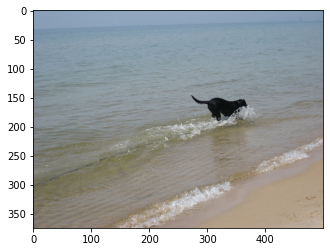

Captioning image: 3640020134_367941f5ec.jpg
Caption sencence: <bos> a dog is running through the water with a stick in its mouth . <eos> 
BLEU score: 0.3851644432598217
Ranking in test set according to BLEU score: 324 of 1619


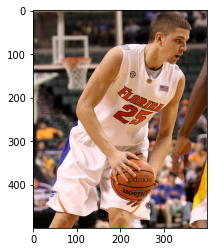

Captioning image: 3148811252_2fa9490a04.jpg
Caption sencence: <bos> a man in a red shirt is playing the violin at a game . <eos> 
BLEU score: 0.33968311024337877
Ranking in test set according to BLEU score: 422 of 1619


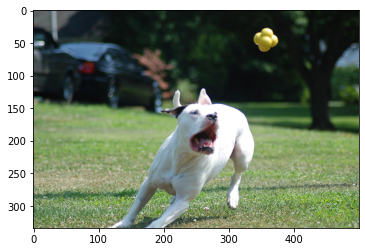

Captioning image: 1019604187_d087bf9a5f.jpg
Caption sencence: <bos> a white dog is running on the grass . <eos> 
BLEU score: 0.44095855184409843
Ranking in test set according to BLEU score: 224 of 1619


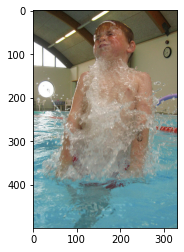

Captioning image: 2660008870_b672a4c76a.jpg
Caption sencence: <bos> a young girl in a bathing suit jumps into the water . <eos> 
BLEU score: 0.3256694736394648
Ranking in test set according to BLEU score: 468 of 1619


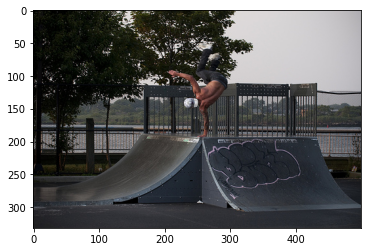

Captioning image: 3728015645_b43a60258b.jpg
Caption sencence: <bos> a boy is doing a trick on a skateboard . <eos> 
BLEU score: 0.5962847939999439
Ranking in test set according to BLEU score: 82 of 1619


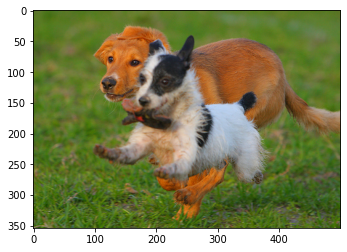

Captioning image: 2313230479_13f87c6bf3.jpg
Caption sencence: <bos> a dog is jumping over a red and white striped obstacle course . <eos> 
BLEU score: 0.18159590803171508
Ranking in test set according to BLEU score: 977 of 1619


In [26]:
files = ["3640020134_367941f5ec.jpg", "3148811252_2fa9490a04.jpg", "1019604187_d087bf9a5f.jpg", "2660008870_b672a4c76a.jpg", "3728015645_b43a60258b.jpg", "2313230479_13f87c6bf3.jpg"]
for file in files:
    sample_presentation(model, file)

**Description:**

#### Bad captions

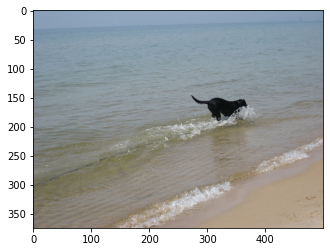

Captioning image: 3640020134_367941f5ec.jpg
Caption sencence: <bos> a dog is running through the water with a stick in its mouth . <eos> 
BLEU score: 0.3851644432598217
Ranking in test set according to BLEU score: 324 of 1619


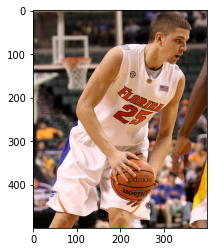

Captioning image: 3148811252_2fa9490a04.jpg
Caption sencence: <bos> a man in a red shirt is playing the violin at a game . <eos> 
BLEU score: 0.33968311024337877
Ranking in test set according to BLEU score: 422 of 1619


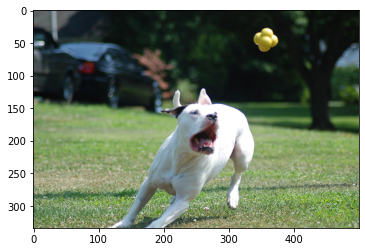

Captioning image: 1019604187_d087bf9a5f.jpg
Caption sencence: <bos> a white dog is running on the grass . <eos> 
BLEU score: 0.44095855184409843
Ranking in test set according to BLEU score: 224 of 1619


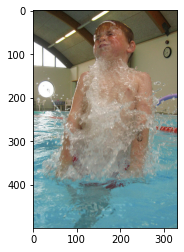

Captioning image: 2660008870_b672a4c76a.jpg
Caption sencence: <bos> a young girl in a bathing suit jumps into the water . <eos> 
BLEU score: 0.3256694736394648
Ranking in test set according to BLEU score: 468 of 1619


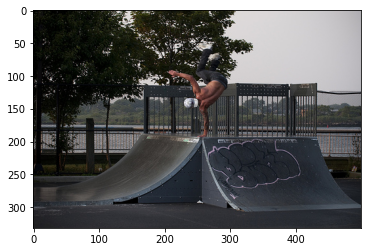

Captioning image: 3728015645_b43a60258b.jpg
Caption sencence: <bos> a boy is doing a trick on a skateboard . <eos> 
BLEU score: 0.5962847939999439
Ranking in test set according to BLEU score: 82 of 1619


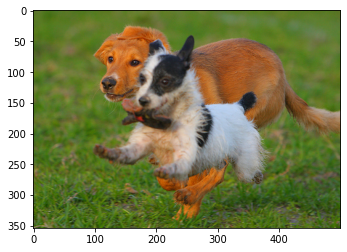

Captioning image: 2313230479_13f87c6bf3.jpg
Caption sencence: <bos> a dog is jumping over a red and white striped obstacle course . <eos> 
BLEU score: 0.18159590803171508
Ranking in test set according to BLEU score: 977 of 1619


In [27]:
files = ["3640020134_367941f5ec.jpg", "3148811252_2fa9490a04.jpg", "1019604187_d087bf9a5f.jpg", "2660008870_b672a4c76a.jpg", "3728015645_b43a60258b.jpg", "2313230479_13f87c6bf3.jpg"]
for file in files:
    sample_presentation(model, file)

**Description:**


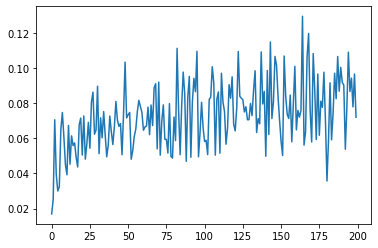

In [33]:
plt.plot(test_bleu)

## Conclusion

Overall, I feel good about the result i was able to achieve. The quality of the captions varied from quite decent to completely off target. I think the model is able to recognize single or multiple objects relatively well, since the resnet18 was also pre-trained for this task. However, I have the impression that the LSTM can not always correctly put the individual objects in relation to each other and mostly just learns a general sentence structure based on memorized patterns. In this context, it would not surprise me if the model could not generate a correct sentence structure for a previously unseen interavtions between known objects. Also, the model generally performs better with objects and scenes that occur frequently in the training dataset. I would therefore argue that the model would be able to increase the quality of the predictions if more similar examples were present in the training data set for the bad captions.
